---
title: Models
subtitle: Validation of MHD data against observations for JUNO mission
---

## Setup

In [1]:
#| hide
%load_ext autoreload
%autoreload 2

In [7]:
from loguru import logger
from typing import Dict

import hvplot.polars

from datetime import timedelta
import numpy as np
import polars as pl
import polars.selectors as cs
from discontinuitypy.utils.polars import pl_norm

In [8]:
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

%load_ext rpy2.ipython

r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Process model data

In [9]:
def overview(df: pl.DataFrame, bcols, vcols):
    """Overview of the data"""
    df_pd = df.to_pandas()
    df_pd.hvplot(x="time", y=bcols)
    
    b_fig = df_pd.hvplot.line(x="time", y=bcols)
    v_fig = df_pd.hvplot.line(x="time", y=vcols)
    rho_fig = df_pd.hvplot.line(x="time", y="rho", logy=True)
    Ti_fig = df_pd.hvplot.line(x="time", y="Ti", logy=True)
    return (b_fig + v_fig + rho_fig + Ti_fig).cols(1).opts(shared_axes=False)

In [10]:
jno_state_data : pl.DataFrame = pl.read_parquet('../data/03_primary/JNO_STATE_ts_3600s.parquet')
jno_state_data.columns

['radial_distance',
 'plasma_density',
 'plasma_temperature',
 'time',
 'model_b_r',
 'model_b_t',
 'model_b_n',
 'v_x',
 'v_y',
 'v_z',
 'plasma_speed',
 'B_background_x',
 'B_background_y',
 'B_background_z']

## Hvplot

In [11]:

time_column = "time"
ts = timedelta(seconds=3600)
every = timedelta(days=3)
###
width = 1600
height = 600

logy = True
alpha = 0.618
###

model_b_col = "MSWIM2D"
juno_b_col = "Juno"

df = (
    jno_state_data.with_columns(
        model_b=pl_norm("model_b_r", "model_b_t", "model_b_n"),
        B_background=pl_norm("B_background_x", "B_background_y", "B_background_z"),
    )
    .sort(time_column)
    .upsample(time_column, every=ts)
    .rename({"model_b": model_b_col, "B_background": juno_b_col})
)

df_avg = df.group_by_dynamic(time_column, every=every).agg(cs.numeric().mean())

panel01 = df_avg.hvplot(
    x=time_column,
    y=[model_b_col, juno_b_col],
    logy=logy,
    color=["red", "black"],
    ylabel="Magnetic Field (nT)",
    width=width,
    height=height,
    xaxis=None,
) * df.hvplot(
    x=time_column,
    y=juno_b_col,
    color="gray",
    alpha=alpha,
    label="Juno (high res)",
    xaxis=None,
)

panel02 = df.hvplot(
    x=time_column, y="radial_distance", width=width, ylabel="Radial Distance (AU)"
)


(panel01.opts(legend_position="top_right") + panel02).cols(1)

:Layout
   .Overlay.I :Overlay
      .NdOverlay.I                                            :NdOverlay   [Variable]
         :Curve   [time]   (value)
      .Curve.Juno_left_parenthesis_high_res_right_parenthesis :Curve   [time]   (Juno)
   .Curve.I   :Curve   [time]   (radial_distance)

## R plot (Publication quality)

In [12]:
%R -i df_avg -c conv_pl
%R -i df -c conv_pl

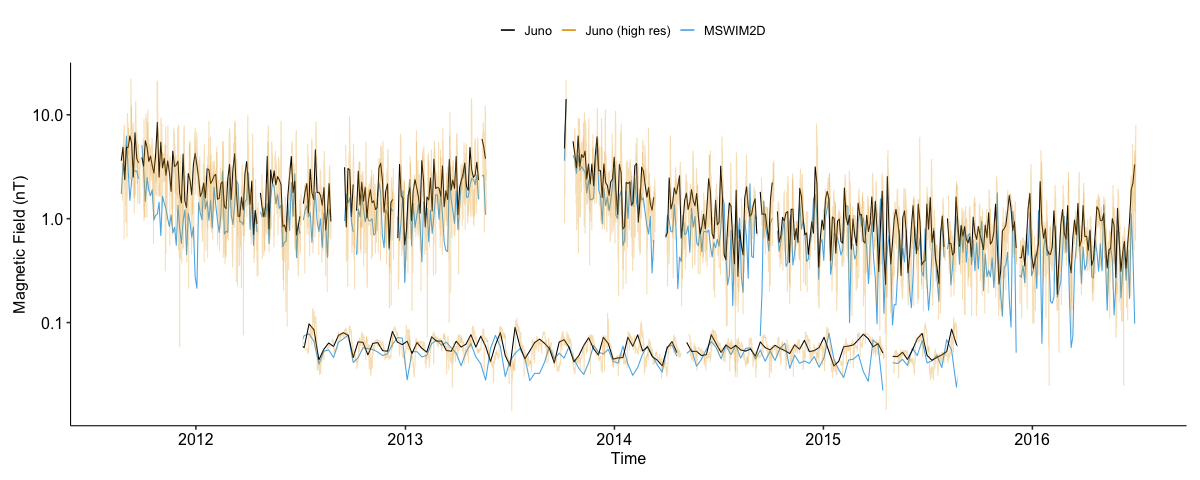

In [15]:
%%R -w 1200
time_column <- "time"
model_b_col <- "MSWIM2D"
juno_b_col <- "Juno"

alpha <- 0.3

filename <- "model/juno_model_validation"


magnetic_field_plot <- ggplot(data = df_avg, aes(x = .data[[time_column]])) +
  geom_line(aes(y = .data[[model_b_col]], color = "MSWIM2D")) +
  geom_line(aes(y = .data[[juno_b_col]], color = "Juno")) +
  geom_line(data = df, aes(y = .data[[juno_b_col]], color = "Juno (high res)"), alpha = alpha) +
  scale_y_log10() +
  labs(y = "Magnetic Field (nT)", x="Time", color=NULL) +
  theme_pubr(base_size = 16, ) +
  scale_color_okabeito(palette = "black_first")

xmin <- as.POSIXct("2015-01-01")
xmax <- as.POSIXct("2015-12-31")

p2 <- magnetic_field_plot + coord_cartesian(xlim = c(xmin, xmax)) + theme_transparent() + theme(legend.position = "none")
magnetic_field_plot + inset_element(p2, 0.2, 0, 0.8, 0.4) 

Saving 16.7 x 13.9 in image
Saving 16.7 x 13.9 in image


In addition: There were 33 warnings (use warnings() to see them)


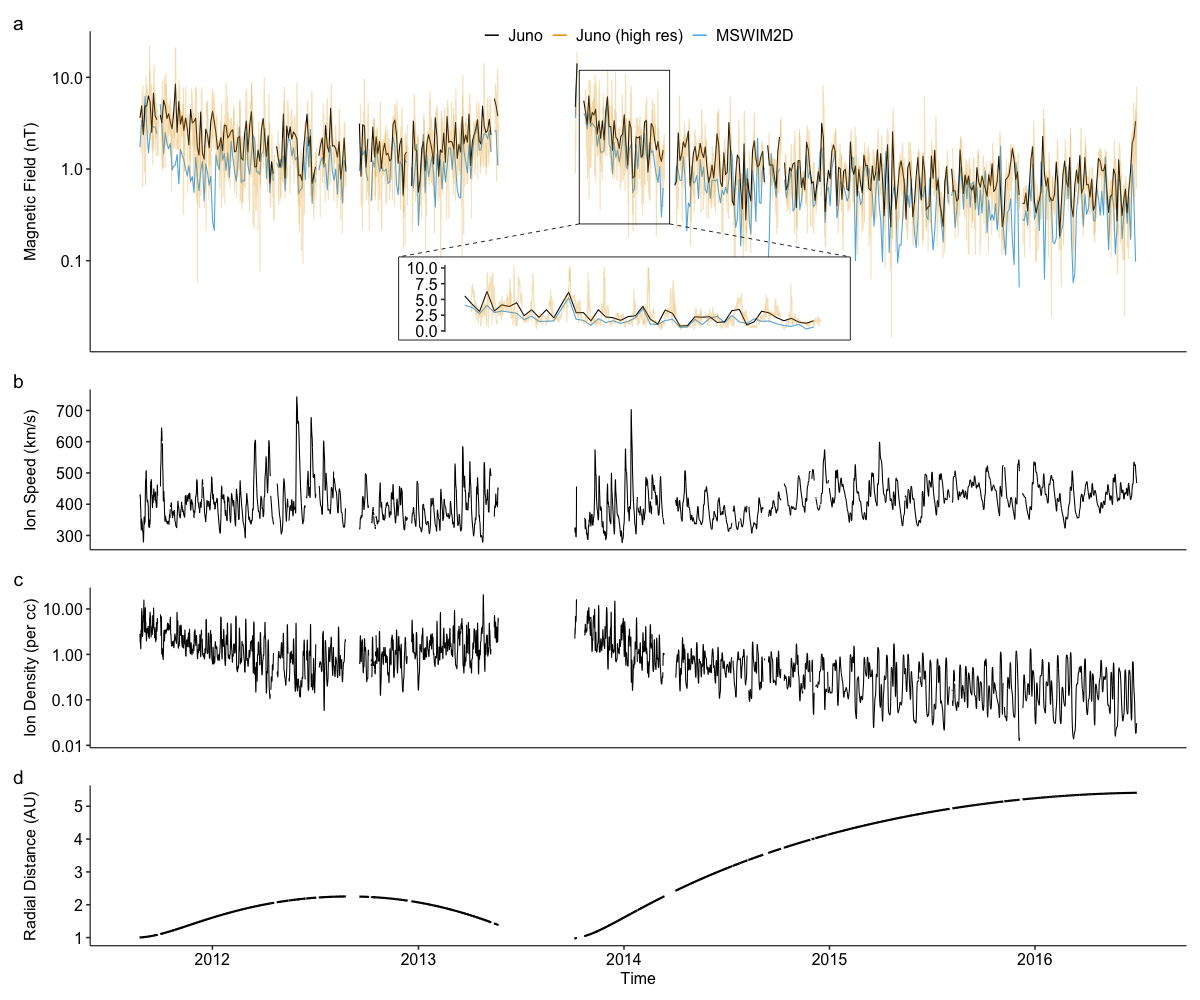

In [28]:
%%R -w 1200 -h 1000
library(ggmagnify)

filename <- "model/juno_model_validation_full"

hide_x = theme(
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.ticks.x = element_blank(),
)

magnetic_field_plot <- ggplot(data = df_avg, aes(x = as.numeric(.data[[time_column]]))) +
  geom_line(aes(y = .data[[model_b_col]], color = "MSWIM2D")) +
  geom_line(aes(y = .data[[juno_b_col]], color = "Juno")) +
  geom_line(data = df, aes(y = .data[[juno_b_col]], color = "Juno (high res)"), alpha = alpha) +
  scale_y_log10() +
  labs(y = "Magnetic Field (nT)", color=NULL) +
  theme_pubr(base_size = 16) +
  scale_color_okabeito(palette = "black_first")

# Computation failed in `stat_magnify()`                                              
# ! no applicable method for 'find_bounds' applied to an object of class "c('POSIXct', 'POSIXt')"

from <- c(xmin = as.numeric(as.POSIXct("2013-10-20")), xmax = as.numeric(as.POSIXct("2014-03-15")), ymin = 0.3, ymax = 10)
to <- c(xmin = as.numeric(as.POSIXct("2013-01-01")), xmax = as.numeric(as.POSIXct("2015-01-01")), ymin = 0.015, ymax = 0.1)

p1 <- magnetic_field_plot + geom_magnify(from = from, to = to, recompute = TRUE, axes="y")  + 
  guides(color = guide_legend(nrow = 1)) +
  hide_x + 
  theme(
    legend.position = c(0.5, 1),   # Center top inside the plot
    legend.text = element_text(size = 16)
  )

# Create the radial distance plot (similar to panel02)
p2 <- ggplot(df, aes(x = .data[[time_column]], y = radial_distance)) +
  geom_line(linewidth=1) +
  labs(x="Time", y = "Radial Distance (AU)") +
  theme_pubr(base_size = 16)

p_n <- ggplot(df, aes(x = .data[[time_column]], y = plasma_density)) +
  geom_line() +
  scale_y_log10() +
  labs(y = "Ion Density (per cc)") +
  theme_pubr(base_size = 16) +
  hide_x
  
p_speed <- ggplot(df, aes(x = .data[[time_column]], y = plasma_speed)) +
  geom_line() +
  labs(y = "Ion Speed (km/s)") +
  theme_pubr(base_size = 16) +
  hide_x

# p <- p1 + p_n + p2 
p <- p1 + p_speed + p_n + p2 + plot_layout(heights = c(2, 1, 1, 1)) + plot_annotation(tag_levels = "a")


save_plot(filename)
print(p)